Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/'

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(root_path,"Train")
data_dir_test = pathlib.Path(root_path,'Test')

In [5]:
# Remove output folders from previous runs of this file (if any)
lst_outpaths = list(data_dir_train.glob('*/output'))
len_outpaths = len(lst_outpaths)
if len_outpaths == 0:
  print("No output folder exists yet!")
else:
  for outpath in range(len_outpaths):
    shutil.rmtree(lst_outpaths[outpath])
    print("Out folder removed: ", lst_outpaths[outpath])

Out folder removed:  gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output
Out folder removed:  gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output
Out folder removed:  gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output
Out folder removed:  gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output
Out folder removed:  gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output
Out folder removed:  gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output
Out folder removed:  gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output
Out 

In [6]:
# Count number of images in train and test folders
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
# Defining parametrs
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Defining train batch dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               batch_size=batch_size, 
                                                               image_size=(img_height, img_width), 
                                                               seed=123, 
                                                               validation_split=0.2, 
                                                               subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Defining validation batch dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                             batch_size=batch_size, 
                                                             image_size=(img_height, img_width), 
                                                             seed=123, 
                                                             validation_split=0.2, 
                                                             subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

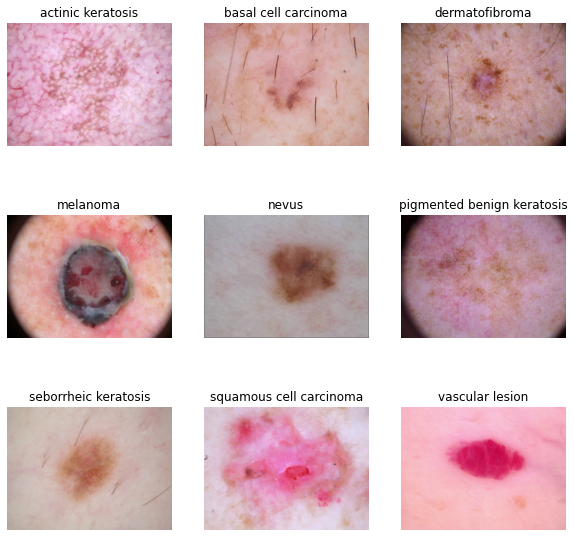

In [11]:
# Visualize one instance of all 9 classes
plt.figure(figsize=(10, 10))
for idx,path in enumerate(class_names):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(PIL.Image.open(str(list(data_dir_train.glob(path+'/*'))[0])))
    plt.title(path)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Base CNN Model 
model = Sequential([
     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
     layers.Conv2D(16,3,padding='same',activation='relu'),
     layers.MaxPool2D(),
     layers.Conv2D(32,3,padding='same',activation='relu'),
     layers.MaxPool2D(),
     layers.Conv2D(64,3,padding='same',activation='relu'),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(128,activation='relu'),
     layers.Dense(9,activation='softmax')
   ])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
# Compile model 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [16]:
# Train model 
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 283s 926ms/step - loss: 2.1324 - accuracy: 0.1953 - val_loss: 2.0161 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.9047 - accuracy: 0.2980 - val_loss: 1.6950 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.6518 - accuracy: 0.4146 - val_loss: 1.4489 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4563 - accuracy: 0.4905 - val_loss: 1.4724 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3581 - accuracy: 0.5212 - val_loss: 1.5774 - val_accuracy: 0.4586
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3211 - accuracy: 0.5463 - val_loss: 1.5941 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2247 - accuracy: 0.5737 - val_loss: 1.3576 - val_accuracy: 0.5436
Epoch 8/20

### Visualizing training results

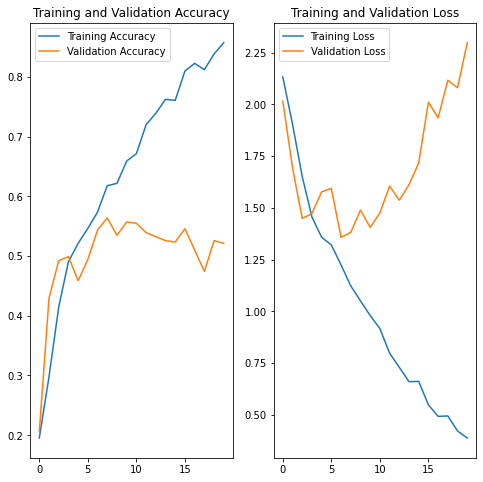

In [17]:
#Visualize model performance on train and validation sets 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings from first model

Model is starting to OVERFIT after few EPOCHS. <br/>
The validation accuracy stays in same range after few EPOCHS, however training accuracy shoots up. <br/>
The validation loss also stayed in closer range, but training loss went down steeply. <br/>
The model is clearly OVERFITTING. <br/>
First thing we will try to avoid overfitting is by using AUGUMENTATION layer randomly augument each image. <br/>
This will ensure slightly different data in each epoch.

In [18]:
# Augumentation strategy
data_augumentation_layers = keras.Sequential([
                         layers.experimental.preprocessing.RandomFlip(input_shape=(img_height, img_width,3)),
                         layers.experimental.preprocessing.RandomRotation(0.1),
                         layers.experimental.preprocessing.RandomZoom(0.1)
                         ])

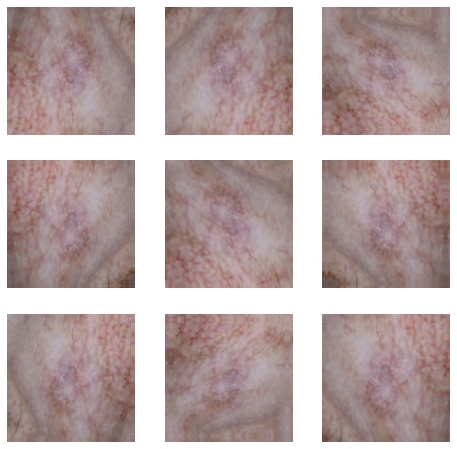

In [19]:
# Visualize augmentation strategy
plt.figure(figsize=(8,8))
for image_batch,label_batch in train_ds.take(1):
# Run first image batch through aug layers for 9 times
  for idx in range(9):
    aug_images=data_augumentation_layers(image_batch)
    ax = plt.subplot(3,3,idx+1)
    # Show first image from image batch with random augumentation applied in each loop
    plt.imshow(aug_images[0].numpy().astype('uint8'))
    plt.axis('off')

### Create the model with augumentation, compile and train the model


In [20]:
# Model with Augumentation
# Not adding DROPOUT here as want to see just the effects of augumentation
model_aug = Sequential([
     data_augumentation_layers,
     layers.experimental.preprocessing.Rescaling(1./255),
     layers.Conv2D(16,3,padding='same',activation='relu'),
     layers.MaxPool2D(),
     layers.Conv2D(32,3,padding='same',activation='relu'),
     layers.MaxPool2D(),
     layers.Conv2D(64,3,padding='same',activation='relu'),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(128,activation='relu'),
     layers.Dense(9,activation='softmax')
   ])

### Compiling the model

In [21]:
# Compile the model
model_aug.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

In [22]:
# View summary of model
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [23]:
# Train model aug
epochs = 20
history = model_aug.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 2s 26ms/step - loss: 1.9458 - accuracy: 0.2762 - val_loss: 1.6782 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6712 - accuracy: 0.4046 - val_loss: 1.6172 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5585 - accuracy: 0.4503 - val_loss: 1.4777 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4486 - accuracy: 0.4844 - val_loss: 1.4045 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4616 - accuracy: 0.4955 - val_loss: 1.4390 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4057 - accuracy: 0.4933 - val_loss: 1.4595 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3117 - accuracy: 0.5346 - val_loss: 1.3099 - val_accuracy: 0.5593
Epoch 8/20
56

### Visualizing the results

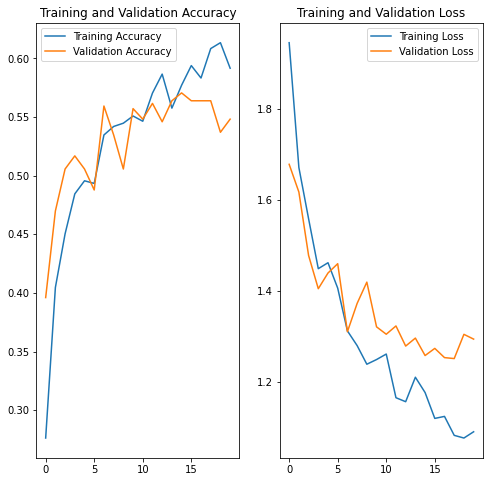

In [24]:
# Visualize resuls for model with augumentation 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model is underfitting as training accuracy went down. <br/>
Validation accuracy however is more closely following training now, so model is BETTER than previous one, which was just learning everything including noise. Still, the accuracy is too low and model is underfitting.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
# Distribution of classes
img_list=[]
for idx,path in enumerate(class_names):
    img_list.append(len(list(data_dir_train.glob(path+'/*'))))
print(class_names)
print(img_list)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[114, 376, 95, 438, 357, 462, 77, 181, 139]


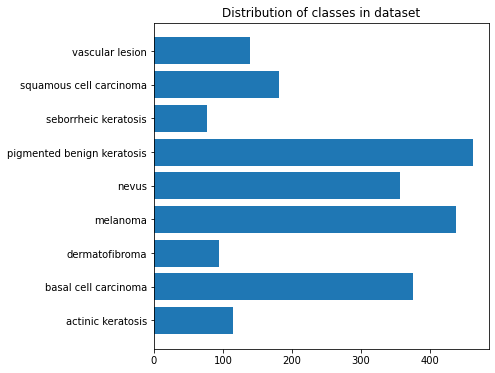

In [26]:
# Visualize distribution of classes
plt.figure(figsize=(6, 6))
plt.title('Distribution of classes in dataset')
plt.barh(class_names,img_list)
plt.show()

#### Class distribution findings: 
#### - Which class has the least number of samples?
seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis, melanoma, basal cell carcinoma, and nevus.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1432197AD0>:   0%|          | 1/500 [00:00<00:56,  8.76 Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1432189B90>: 100%|██████████| 500/500 [00:18<00:00, 27.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F143205BB50>: 100%|██████████| 500/500 [00:18<00:00, 27.28 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14321A58D0>:   0%|          | 1/500 [00:00<01:13,  6.83 Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1432197750>: 100%|██████████| 500/500 [00:19<00:00, 25.61 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F143206B810>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1432123E50>: 100%|██████████| 500/500 [01:16<00:00,  6.50 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1432070190>: 100%|██████████| 500/500 [00:18<00:00, 26.72 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1491E71890>: 100%|██████████| 500/500 [00:41<00:00, 12.12 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F143217CDD0>: 100%|██████████| 500/500 [00:19<00:00, 26.18 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1432680ED0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1491D0D910>: 100%|██████████| 500/500 [00:18<00:00, 26.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
# Distribution of classes after augumentation (training data + augumentation output)
img_list_aug=[]
for idx,path in enumerate(class_names):
    img_list_aug.append(len(list(data_dir_train.glob(path+'/output/*'))))
img_list_aug = [a+b for a,b in zip(img_list_aug, img_list)]
print(class_names)
print(img_list_aug)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[614, 876, 595, 938, 857, 962, 577, 681, 639]


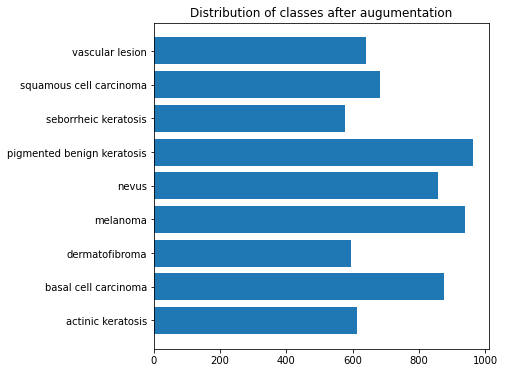

In [31]:
# Visualize distribution of classes after augumentation (training data + augumentation output)
plt.figure(figsize=(6, 6))
plt.title('Distribution of classes after augumentation')
plt.barh(class_names,img_list_aug)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
# Defining train batch dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               batch_size=batch_size, 
                                                               image_size=(img_height, img_width), 
                                                               seed=123, 
                                                               validation_split=0.2, 
                                                               subset="training")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [34]:
# Defining validation batch dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               batch_size=batch_size, 
                                                               image_size=(img_height, img_width), 
                                                               seed=123, 
                                                               validation_split=0.2, 
                                                               subset="validation")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
# Model on augumented data
model_final = Sequential([
     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
     layers.Conv2D(16,3,padding='same',activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPool2D(),
     layers.Dropout(0.2),
     layers.Conv2D(32,3,padding='same',activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPool2D(),
     layers.Dropout(0.2),
     layers.Conv2D(64,3,padding='same',activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPool2D(),
     layers.Dropout(0.2),
     layers.Flatten(),
     layers.Dense(128,activation='relu'),
     layers.Dropout(0.2),
     layers.Dense(9,activation='softmax')
   ])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
# Compile final mode
model_final.compile(optimizer='adam', 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=['accuracy'])

#### **Todo:**  Train your model

In [37]:
epochs = 30
history = model_final.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 33s 189ms/step - loss: 2.5966 - accuracy: 0.2756 - val_loss: 14.3254 - val_accuracy: 0.1811
Epoch 2/30
169/169 [==============================] - 32s 183ms/step - loss: 1.7792 - accuracy: 0.3190 - val_loss: 9.9066 - val_accuracy: 0.2457
Epoch 3/30
169/169 [==============================] - 31s 181ms/step - loss: 1.6313 - accuracy: 0.3620 - val_loss: 8.6828 - val_accuracy: 0.2710
Epoch 4/30
169/169 [==============================] - 31s 180ms/step - loss: 1.5602 - accuracy: 0.3922 - val_loss: 3.0376 - val_accuracy: 0.3727
Epoch 5/30
169/169 [==============================] - 31s 178ms/step - loss: 1.4901 - accuracy: 0.4154 - val_loss: 1.6190 - val_accuracy: 0.4224
Epoch 6/30
169/169 [==============================] - 31s 177ms/step - loss: 1.4270 - accuracy: 0.4440 - val_loss: 1.9172 - val_accuracy: 0.3378
Epoch 7/30
169/169 [==============================] - 31s 178ms/step - loss: 1.3287 - accuracy: 0.4744 - val_loss: 2.0012 - val_a

#### **Todo:**  Visualize the model results

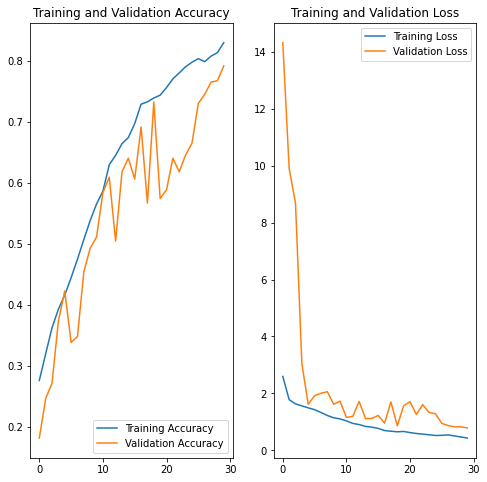

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In final model, we introduced batchnormalization and drop out after each convolution layer. This helped in fixing overfitting problem. <br/>
We also rebalanced the data so that model trains on enough data for each class, and so with that we avoided the problem of underfitting (that we had with model#2). <br/>
CONCLUSION: Final model is performing well with both training and validation accuracy around 80%. <br/>
Yes, we were able to get rid of overfitting and underfitting, and the model now performs decently on both training and validation data.

In [45]:
#Testing on a sample test image
test_img = keras.preprocessing.image.load_img(
    str(list(data_dir_test.glob('nevus/*.jpg'))[0]), target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(test_img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model_final.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to nevus with a 25.02 percent confidence.
